In [38]:
# importing required libraries
import os
import cv2
import glob
import random
import time
import warnings
import pandas as pd
import numpy as np
import disarray as da
import seaborn as sns
import tensorflow as tf
from imutils import paths
from itertools import cycle
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
#importing sklearn libraries
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report, matthews_corrcoef

In [18]:
base_path = "/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/bytes_images" # Data Path 
img_list = glob.glob(os.path.join(base_path, '*/*.png'))

In [19]:
cur_dir = os.getcwd()
os.chdir(base_path)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family

for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
fam = []
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
        fam.append(list_fams[label])
    label += 1
num_classes = label

Label: 0	Family:           Gatak	Number of images: 1013
Label: 1	Family:    Kelihos_ver1	Number of images: 398
Label: 2	Family:    Kelihos_ver3	Number of images: 2942
Label: 3	Family:        Lollipop	Number of images: 2478
Label: 4	Family:  Obfuscator.ACY	Number of images: 1228
Label: 5	Family:          Ramnit	Number of images: 1541
Label: 6	Family:           Simda	Number of images: 42
Label: 7	Family:          Tracur	Number of images: 751
Label: 8	Family:           Vundo	Number of images: 475


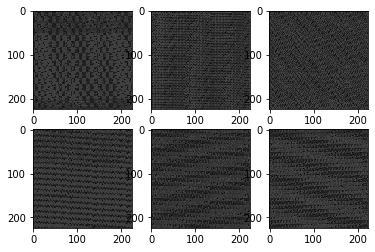

In [20]:
# Sample images from dataset
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [21]:
#loading data
X = np.load("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/bytes_Plots/X.npy")
X.shape

(10868, 224, 224, 3)

In [22]:
#loading labels
labels = np.load("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/bytes_Plots/y.npy")
labels.shape

(10868,)

In [23]:
y_cat = to_categorical(y, num_classes=9)
y_cat.shape

(10868, 9)

In [24]:
IMG_SHAPE = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                                    include_top=False,
                                                    weights='imagenet')
base_model.trainable = False

In [25]:
base_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

                                                                                                  
 expanded_conv_2/depthwise/Batc  (None, 56, 56, 72)  288         ['expanded_conv_2/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_44 (ReLU)                (None, 56, 56, 72)   0           ['expanded_conv_2/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_2/project (Conv2  (None, 56, 56, 24)  1728        ['re_lu_44[0][0]']               
 D)                                                                                               
                                                                                                  
 expanded_

                                                                                                  
 re_lu_49 (ReLU)                (None, 28, 28, 120)  0           ['expanded_conv_4/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 120)   0           ['re_lu_49[0][0]']               
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 32)    3872        ['expanded_conv_4/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
          

                                                                                                  
 expanded_conv_5/project/BatchN  (None, 28, 28, 40)  160         ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_5/Add (Add)      (None, 28, 28, 40)   0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 28, 28, 240)  9600       ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
          

 a)                                                                                               
                                                                                                  
 multiply_24 (Multiply)         (None, 14, 14, 200)  0           ['expanded_conv_7/depthwise/Batch
                                                                 Norm[0][0]',                     
                                                                  'tf.math.multiply_35[0][0]']    
                                                                                                  
 expanded_conv_7/project (Conv2  (None, 14, 14, 80)  16000       ['multiply_24[0][0]']            
 D)                                                                                               
                                                                                                  
 expanded_conv_7/project/BatchN  (None, 14, 14, 80)  320         ['expanded_conv_7/project[0][0]']
 orm (Batc

                                                                                                  
 expanded_conv_9/depthwise/Batc  (None, 14, 14, 184)  736        ['expanded_conv_9/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_39 (TFOpL  (None, 14, 14, 184)  0          ['expanded_conv_9/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_61 (ReLU)                (None, 14, 14, 184)  0           ['tf.__operators__.add_39[0][0]']
                                                                                                  
 tf.math.multiply_39 (TFOpLambd  (None, 14, 14, 184)  0          ['re_lu_61[0][0]']               
 a)       

 expanded_conv_10/squeeze_excit  (None, 14, 14, 480)  0          ['multiply_30[0][0]',            
 e/Mul (Multiply)                                                 'tf.math.multiply_42[0][0]']    
                                                                                                  
 expanded_conv_10/project (Conv  (None, 14, 14, 112)  53760      ['expanded_conv_10/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_conv_10/project/Batch  (None, 14, 14, 112)  448        ['expanded_conv_10/project[0][0]'
 Norm (BatchNormalization)                                       ]                                
                                                                                                  
 expanded_conv_11/expand (Conv2  (None, 14, 14, 672)  75264      ['expanded_conv_10/project/BatchN
 D)       

 expanded_conv_12/expand/BatchN  (None, 14, 14, 672)  2688       ['expanded_conv_12/expand[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 tf.__operators__.add_46 (TFOpL  (None, 14, 14, 672)  0          ['expanded_conv_12/expand/BatchNo
 ambda)                                                          rm[0][0]']                       
                                                                                                  
 re_lu_68 (ReLU)                (None, 14, 14, 672)  0           ['tf.__operators__.add_46[0][0]']
                                                                                                  
 tf.math.multiply_46 (TFOpLambd  (None, 14, 14, 672)  0          ['re_lu_68[0][0]']               
 a)                                                                                               
          

                                                                                                  
 expanded_conv_13/depthwise (De  (None, 7, 7, 960)   24000       ['multiply_35[0][0]']            
 pthwiseConv2D)                                                                                   
                                                                                                  
 expanded_conv_13/depthwise/Bat  (None, 7, 7, 960)   3840        ['expanded_conv_13/depthwise[0][0
 chNorm (BatchNormalization)                                     ]']                              
                                                                                                  
 tf.__operators__.add_50 (TFOpL  (None, 7, 7, 960)   0           ['expanded_conv_13/depthwise/Batc
 ambda)                                                          hNorm[0][0]']                    
                                                                                                  
 re_lu_72 

 tf.math.multiply_53 (TFOpLambd  (None, 7, 7, 960)   0           ['re_lu_75[0][0]']               
 a)                                                                                               
                                                                                                  
 multiply_38 (Multiply)         (None, 7, 7, 960)    0           ['expanded_conv_14/depthwise/Batc
                                                                 hNorm[0][0]',                    
                                                                  'tf.math.multiply_53[0][0]']    
                                                                                                  
 expanded_conv_14/squeeze_excit  (None, 1, 1, 960)   0           ['multiply_38[0][0]']            
 e/AvgPool (GlobalAveragePoolin                                                                   
 g2D)                                                                                             
          

In [26]:
model = tf.keras.Sequential([base_model,
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(9, activation='softmax')])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 7, 7, 512)         492032    
                                                                 
 dense_5 (Dense)             (None, 7, 7, 256)         131328    
                                                                 
 dense_6 (Dense)             (None, 7, 7, 128)         32896     
                                                                 
 global_average_pooling2d_1   (None, 128)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 9)                

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [29]:
#data train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.20, random_state=42)

In [30]:
X_train.shape, X_test.shape 

((8694, 224, 224, 3), (2174, 224, 224, 3))

In [31]:
batch_size = 32
epochs = 50

In [32]:
%%time
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(X_test, y_test))

Epoch 1/50
272/272 [==============================] - 62s 209ms/step - loss: 2.0238 - accuracy: 0.2476 - val_loss: 1.9218 - val_accuracy: 0.2714
Epoch 2/50
272/272 [==============================] - 48s 177ms/step - loss: 1.9061 - accuracy: 0.2810 - val_loss: 1.9046 - val_accuracy: 0.2714
Epoch 3/50
272/272 [==============================] - 50s 182ms/step - loss: 1.8957 - accuracy: 0.2705 - val_loss: 1.8964 - val_accuracy: 0.2714
Epoch 4/50
272/272 [==============================] - 45s 166ms/step - loss: 1.8915 - accuracy: 0.2705 - val_loss: 1.8924 - val_accuracy: 0.2714
Epoch 5/50
272/272 [==============================] - 46s 168ms/step - loss: 1.8877 - accuracy: 0.2705 - val_loss: 1.8887 - val_accuracy: 0.2714
Epoch 6/50
272/272 [==============================] - 45s 166ms/step - loss: 1.8841 - accuracy: 0.2747 - val_loss: 1.8848 - val_accuracy: 0.2714
Epoch 7/50
272/272 [==============================] - 45s 167ms/step - loss: 1.8806 - accuracy: 0.2715 - val_loss: 1.8820 - val_ac

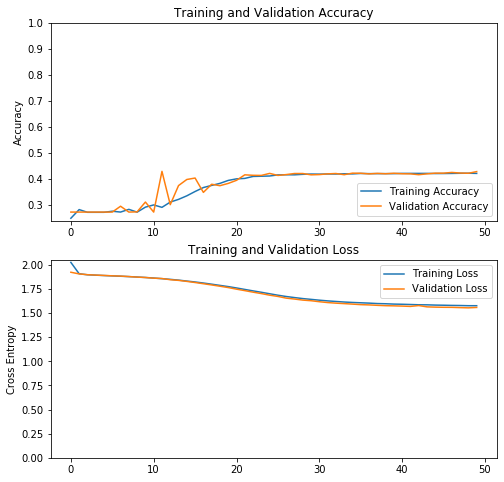

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [34]:
%%time
score = model.evaluate(X_test, y_test, verbose=1)
print("Model evaluated!!")
print('Test loss:', score[0])
print('Test accuracy:', score[1])

68/68 [==============================] - 9s 132ms/step - loss: 1.5572 - accuracy: 0.4273
Model evaluated!!
Test loss: 1.5572128295898438
Test accuracy: 0.4273228943347931
CPU times: user 4min 6s, sys: 2min 2s, total: 6min 9s
Wall time: 10.9 s


In [35]:
%%time
#predictions for test data
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print("Prediction done!!")

Prediction done!!
CPU times: user 4min 1s, sys: 2min 19s, total: 6min 20s
Wall time: 12.2 s


In [36]:
preds = np.round(model.predict(X_test), 0)

In [39]:
classification_metrices = metrics.classification_report(y_test, preds, output_dict=True, target_names=list_fams)
df = pd.DataFrame(classification_metrices).transpose()
df.to_csv('/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/bytes_Plots/mobilenetV3_large_classification_report.csv')

In [40]:
classification_metrices = metrics.classification_report(y_test, preds, target_names= list_fams)
print(classification_metrices)

                precision    recall  f1-score   support

         Gatak       0.00      0.00      0.00       209
  Kelihos_ver1       0.00      0.00      0.00        76
  Kelihos_ver3       0.92      0.84      0.88       590
      Lollipop       0.00      0.00      0.00       487
Obfuscator.ACY       0.00      0.00      0.00       232
        Ramnit       0.00      0.00      0.00       317
         Simda       0.00      0.00      0.00         7
        Tracur       0.00      0.00      0.00       150
         Vundo       0.00      0.00      0.00       106

     micro avg       0.92      0.23      0.36      2174
     macro avg       0.10      0.09      0.10      2174
  weighted avg       0.25      0.23      0.24      2174
   samples avg       0.23      0.23      0.23      2174



Plotting the confusion matrix


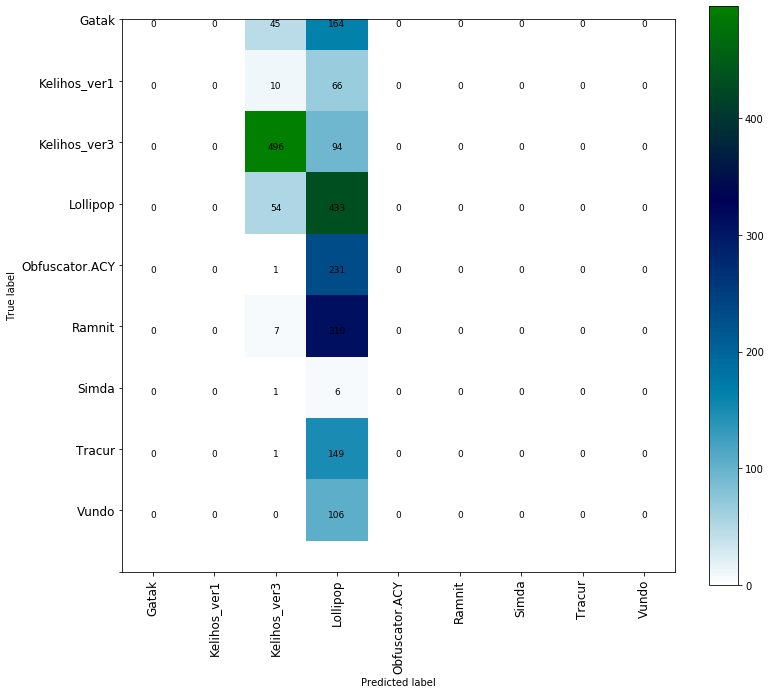

In [41]:
conf_matrix = confusion_matrix(y_true, y_pred)

print("Plotting the confusion matrix")
conf_mat = np.around(conf_matrix, decimals=2)  
figure = plt.gcf()
figure.set_size_inches(11, 10)
plt.imshow(conf_mat, interpolation='nearest', cmap='ocean_r')

for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]), xy=(col,row), ha='center', va='top', fontsize=9)
        
plt.xticks(range(len(list_fams)), list_fams, rotation=90, fontsize=12)
plt.yticks(range(len(list_fams)+1), list_fams, fontsize=12)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.colorbar()

plt.savefig("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/bytes_Plots/mobilenetV3Large_cm.eps", bbox_inches='tight')
plt.savefig("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/bytes_Plots/mobilenetV3Large_cm.png", bbox_inches='tight')
plt.show()

In [42]:
cm = confusion_matrix(y_true, y_pred)
df = pd.DataFrame(cm)

In [43]:
pd.set_option('display.max_columns', None)  # force to display any number of columns.

In [44]:
#calculating true positives, false positives, true negatives and false negatives from confusion matrix
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [45]:
FP, FN, TP, TN

(array([   0,    0,  119, 1126,    0,    0,    0,    0,    0]),
 array([209,  76,  94,  54, 232, 317,   7, 150, 106]),
 array([  0,   0, 496, 433,   0,   0,   0,   0,   0]),
 array([1965, 2098, 1465,  561, 1942, 1857, 2167, 2024, 2068]))

In [46]:
#calculating false_omission_rate
NPV = TN/(TN+FN)
FOR = 1-NPV
FOR

array([0.09613615, 0.0349586 , 0.06029506, 0.08780488, 0.10671573,
       0.14581417, 0.00321987, 0.06899724, 0.04875805])

In [47]:
data = df.da.export_metrics(metrics_to_include=['true_positive_rate', 'true_negative_rate', 'false_positive_rate', 
                                              'false_negative_rate', 'false_discovery_rate'])

In [48]:
data.fillna(0.0, inplace=True)

In [49]:
for num, fam in zip(range(25), list_fams):
    data.rename(columns={data.columns[num]:fam}, inplace=True)

data1 = data.drop(columns=['micro-average'])
data1 = data1.T
# data.drop(df.tail(1).index,inplace=True)

data1['false_omission_rate'] = list(FOR)

data1

,true_positive_rate,true_negative_rate,false_positive_rate,false_negative_rate,false_discovery_rate,false_omission_rate
Gatak,0.000000,1.000000,0.000000,1.000000,0.000000,0.096136
Kelihos_ver1,0.000000,1.000000,0.000000,1.000000,0.000000,0.034959
Kelihos_ver3,0.840678,0.924874,0.075126,0.159322,0.193496,0.060295
Lollipop,0.889117,0.332543,0.667457,0.110883,0.722258,0.087805
Obfuscator.ACY,0.000000,1.000000,0.000000,1.000000,0.000000,0.106716
Ramnit,0.000000,1.000000,0.000000,1.000000,0.000000,0.145814
Simda,0.000000,1.000000,0.000000,1.000000,0.000000,0.003220
Tracur,0.000000,1.000000,0.000000,1.000000,0.000000,0.068997
Vundo,0.000000,1.000000,0.000000,1.000000,0.000000,0.048758


In [50]:
for i in data1:
    print('Average of', i, '-->', round((np.average(data1[i])*100), 4))

Average of true_positive_rate --> 19.2199
Average of true_negative_rate --> 91.7491
Average of false_positive_rate --> 8.2509
Average of false_negative_rate --> 80.7801
Average of false_discovery_rate --> 10.175
Average of false_omission_rate --> 7.2522


In [51]:
#MCC value
print('MCC Score:', round(matthews_corrcoef(y_true, y_pred), 2))

MCC Score: 0.33


In [52]:
preds

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [53]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [54]:
n_classes = 9

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

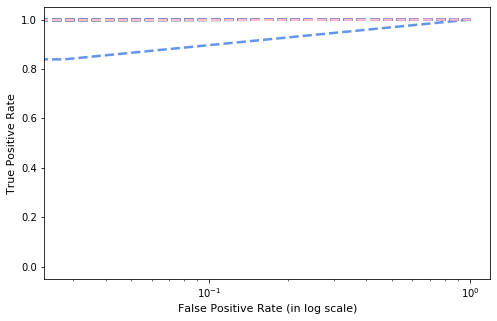

In [55]:
# Compute macro-average ROC curve and ROC area

n_classes = 9
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2.5   # line width
plt.figure(figsize=(8,5))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'lightgreen', 'green', 'red', 'cyan', 'blue', 
                 'pink', 'purple', 'brown', 'coral', 'chocolate', 'indigo', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linestyle='dashed', lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.xscale("log")
plt.xlabel('False Positive Rate (in log scale)', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)

plt.savefig("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/bytes_Plots/mobilenetV3Large_roc.eps", bbox_inches='tight')
plt.savefig("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/bytes_Plots/mobilenetV3Large_roc.png", bbox_inches='tight')

plt.show()